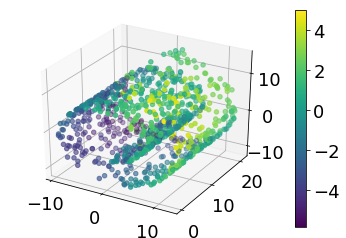

1/300 ... likelihood: -2158.8150215992405
2/300 ... likelihood: -2120.56728941762
3/300 ... likelihood: -2119.4308543733805
4/300 ... likelihood: -2118.4448494143453
5/300 ... likelihood: -2117.495530632323
6/300 ... likelihood: -2116.5064201010555
7/300 ... likelihood: -2115.408263790822
8/300 ... likelihood: -2114.1214093885264
9/300 ... likelihood: -2112.538734260261
10/300 ... likelihood: -2110.5054909663913
11/300 ... likelihood: -2107.7940099669995
12/300 ... likelihood: -2104.074731411798
13/300 ... likelihood: -2098.894237666947
14/300 ... likelihood: -2091.688889021606
15/300 ... likelihood: -2081.879946632348
16/300 ... likelihood: -2069.0785398649186
17/300 ... likelihood: -2053.345035792725
18/300 ... likelihood: -2035.3149261753679
19/300 ... likelihood: -2015.9869929982965
20/300 ... likelihood: -1996.3994194593406
21/300 ... likelihood: -1977.6570726587397
22/300 ... likelihood: -1960.9780405833867
23/300 ... likelihood: -1947.3069864765275
24/300 ... likelihood: -1936.8

192/300 ... likelihood: -1635.0683189782685
193/300 ... likelihood: -1635.0655931555505
194/300 ... likelihood: -1635.0630538185483
195/300 ... likelihood: -1635.0606796706331
196/300 ... likelihood: -1635.0584525318586
197/300 ... likelihood: -1635.0563568167863
198/300 ... likelihood: -1635.0543791115433
199/300 ... likelihood: -1635.0525078293504
200/300 ... likelihood: -1635.0507329280397
201/300 ... likelihood: -1635.0490456756415
202/300 ... likelihood: -1635.0474384554864
203/300 ... likelihood: -1635.0459046025221
204/300 ... likelihood: -1635.0444382673459
205/300 ... likelihood: -1635.0430343001005
206/300 ... likelihood: -1635.0416881525957
207/300 ... likelihood: -1635.0403957950634
208/300 ... likelihood: -1635.0391536455231
209/300 ... likelihood: -1635.0379585097082
210/300 ... likelihood: -1635.0368075292922
211/300 ... likelihood: -1635.0356981375144
212/300 ... likelihood: -1635.034628021173
213/300 ... likelihood: -1635.0335950884596
214/300 ... likelihood: -1635.032

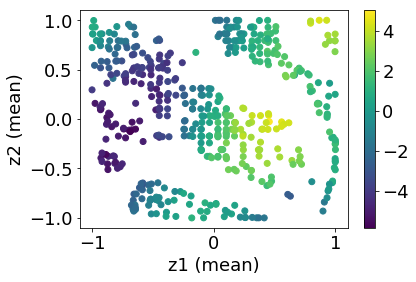

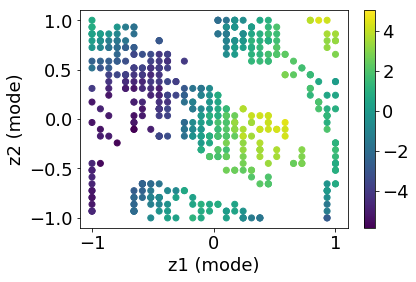

r2p: 0.9879512299100454
RMSEp: 0.2727401768202897
MAEp: 0.21877088815262016


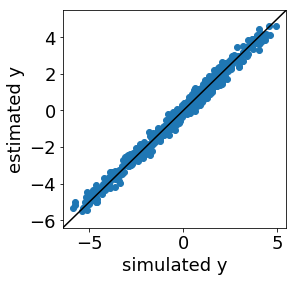

In [1]:
# -*- coding: utf-8 -*- 
# %reset -f
"""
@author: Hiromasa Kaneko
"""
%matplotlib inline
# Demonstration of GTM-MLR (Generative Topographic Mapping - Multiple Linear Regression)

import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.datasets.samples_generator import make_swiss_roll
import mpl_toolkits.mplot3d

from gtm import gtm

# settings
shape_of_map = [30, 30]
shape_of_rbf_centers = [4, 4]
variance_of_rbfs = 0.5
lambda_in_em_algorithm = 0.001
number_of_iterations = 300
display_flag = 1
number_of_samples = 1000
noise_ratio_of_y = 0.1
random_state_number = 30000

# load a swiss roll dataset and make a y-variable
original_X, color = make_swiss_roll(number_of_samples, 0, random_state=10)
X = original_X
raw_y = 0.3 * original_X[:, 0] - 0.1 * original_X[:, 1] + 0.2 * original_X[:, 2]
original_y = raw_y + noise_ratio_of_y * raw_y.std(ddof=1) * np.random.randn(len(raw_y))
# plot
plt.rcParams["font.size"] = 18
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(original_X[:, 0], original_X[:, 1], original_X[:, 2], c=original_y)
fig.colorbar(p)
plt.show()

# divide a dataset into training data and test data
Xtrain = original_X[:500, :]
ytrain = original_y[:500]
Xtest = original_X[500:, :]
ytest = original_y[500:]

# autoscaling
# autoscaled_X = (original_X - original_X.mean(axis=0)) / original_X.std(axis=0,ddof=1)
autoscaled_Xtrain = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0, ddof=1)
# autoscaled_Xtest = (Xtest - X.mean(axis=0)) / X.std(axis=0,ddof=1)
# autoscaled_ytrain = (ytrain - ytrain.mean()) / ytrain.std(ddof=1)

# construct GTM model
model = gtm(shape_of_map, shape_of_rbf_centers, variance_of_rbfs, lambda_in_em_algorithm, number_of_iterations,
            display_flag)
model.fit(autoscaled_Xtrain)
if model.success_flag:
    # calculate of responsibilities
    responsibilities = model.responsibility(autoscaled_Xtrain)

    # plot the mean of responsibilities
    means = responsibilities.dot(model.map_grids)
    plt.figure()
    #    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(means[:, 0], means[:, 1], c=ytrain)
    plt.colorbar()
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    plt.xlabel("z1 (mean)")
    plt.ylabel("z2 (mean)")
    plt.show()

    # plot the mode of responsibilities
    modes = model.map_grids[responsibilities.argmax(axis=1), :]
    plt.figure()
    #    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(modes[:, 0], modes[:, 1], c=ytrain)
    plt.colorbar()
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    plt.xlabel("z1 (mode)")
    plt.ylabel("z2 (mode)")
    plt.show()

# construct MLR model
model.mlr(Xtrain, ytrain)

# MLR prediction
predicted_ytest = np.ndarray.flatten(model.mlr_predict(Xtest))

# r2p, RMSEp, MAEp
print("r2p: {0}".format(float(1 - sum((ytest - predicted_ytest) ** 2) / sum((ytest - ytest.mean()) ** 2))))
print("RMSEp: {0}".format(float((sum((ytest - predicted_ytest) ** 2) / len(ytest)) ** (1 / 2))))
print("MAEp: {0}".format(float(sum(abs(ytest - predicted_ytest)) / len(ytest))))
# yy-plot
plt.figure(figsize=figure.figaspect(1))
plt.scatter(ytest, predicted_ytest)
YMax = np.max(np.array([np.array(ytest), predicted_ytest]))
YMin = np.min(np.array([np.array(ytest), predicted_ytest]))
plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
         [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlabel("simulated y")
plt.ylabel("estimated y")
plt.show()
